<h1><center> <b> Group 18: Facial Expression Recognition Using Deep Learning </b> </center></h1>
<div style="text-align: right"> <b>Pravin Dhuri | NUID: 002138314</b>  </div>
<div style="text-align: right"> <b>Manisha Iyer | NUID: 001568173</b>  </div>

## Index

[Problem Statement](#Problem-Statement)

[Importance and Solution](#Importance-and-Solution)

[Technical Approach](#Technical-Approach)

> [Importing Libraries and packages](#Importing-Libraries-and-packages)

> [Harvesting Data](#Harvesting-Data)

> [Image Augmentation](#Image-Augmentation)

[Model Implementation](#Model-Implementation)

> [Convolutional Neural Network](#Convolutional-Neural-Network)

[Transfer Learning Architecture](#Transfer-Learning-Architecture)

>[ResNet50 Architecture](#ResNet50-Architecture)

>[Xception Architecture](#Xception-Architecture)

[Summary/Testing Model](#Summary)

[Challenges](#Challenges)

[References](#References)

## Problem Statement

Because of technological advancement and the pervasiveness of these mediums, we now spend the majority of our time interacting with computers and mobile phones in our daily lives. They do, however, play an important role in our lives, and the vast majority of existing software interfaces are nonverbal, primitive, and cryptic. The addition of emotional expression recognition to anticipate the users' feelings and emotional state can significantly improve human-computer interaction. Human-computer interaction has been regarded as one of the most appealing and rapidly developing fields, and as a result, human-robotic interactions (HRI) and healthcare systems have grown impressively and rapidly.

## Importance and Solution

Humans typically express their emotions through various cues such as facial expressions, hand gestures, and voice. Facial expressions account for up to 55% of human communications, while oral language accounts for only 7% of emotion expression. As a result, using facial expressions in an HRI system successfully simulates natural interactions. Indeed, when robots can analyze facial expressions and determine their emotional states, they can easily interact with humans in the most friendly manner possible. As a result, they can be used in a healthcare system to detect human mental states via emotion analysis and improve quality of life.

![FER](https://miro.medium.com/max/996/1*Gkbf0PuGyxRht_ngfTC2cA.gif "FER")

## Technical Approach

### Importing Libraries and packages

In [1]:
%config Completer.use_jedi = False
import os
os.environ["KMP_SETTINGS"] = "false"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scikitplot
import seaborn as sns

from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from pickle import load

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import top_k_accuracy_score

## Harvesting Data

***
<b>Dataset Description:</b>
The data consists of grayscale images of faces 48x48 pixels in size. The faces have been automatically registered so that they are roughly centered and take up roughly the same amount of space in each image. The "emotion" column contains a numeric code ranging from 0 to 6 for the emotion depicted in the image. For each image, the "pixels" column contains a string surrounded by quotes.
[Dataset](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data)
***

In [2]:
train = pd.read_csv('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


<div class="alert alert-block alert-info">
<b>Observation:</b>
    
We discovered the first challenge after scouring the dataset. We don't have any images with which to train our model. Instead, we have the pixels from each image. We need to convert those pixels into a format that will allow us to visualize and prepare our algorithms.
    
</div>

In [3]:
# Convert the pixels values from a string to a numpy array

train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train['pixels']]

In [4]:
# Assign the emotions to the corresponding number and apply them to the DataFrame

emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}
train['emotion'] = train['emotion'].apply(lambda x: emotion_cat[x])

In [5]:
# Create variables for pixels and labels

pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

In [6]:
# Calculate the proportions for each emotion

emotion_prop = (train.emotion.value_counts() / len(train)).to_frame().sort_index(ascending=True)
emotion_prop

,emotion
Anger,0.139155
Disgust,0.015187
Fear,0.142708
Happiness,0.251315
Neutral,0.172942
Sadness,0.168240
Surprise,0.110453


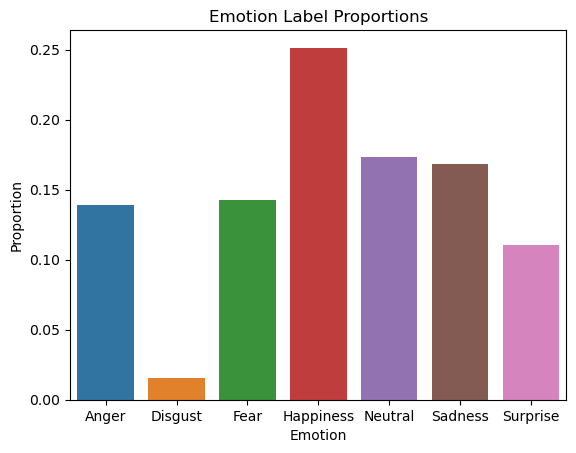

In [7]:
ax = sns.barplot( x=emotion_prop.index, y=emotion_prop['emotion'])
ax.set(xlabel='Emotion', ylabel='Proportion')
plt.title('Emotion Label Proportions')
plt.show()

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
According to the table and bar chart, the proportion of images labeled with disgust is significantly lower than the other labels. Furthermore, the proportion of images labeled as happy is significantly higher than the proportion of images labeled as sad. Both of these observations suggest that we are not dealing with balanced classes. Imbalanced classes may cause CNN models to perform poorly, particularly for the disgust label. Our instincts tell us that images depicting disgust will be the most easily confused with images depicting anger. A confusion matrix for our final model will show if the disgust class performs worse than the other classes.
    
</div>

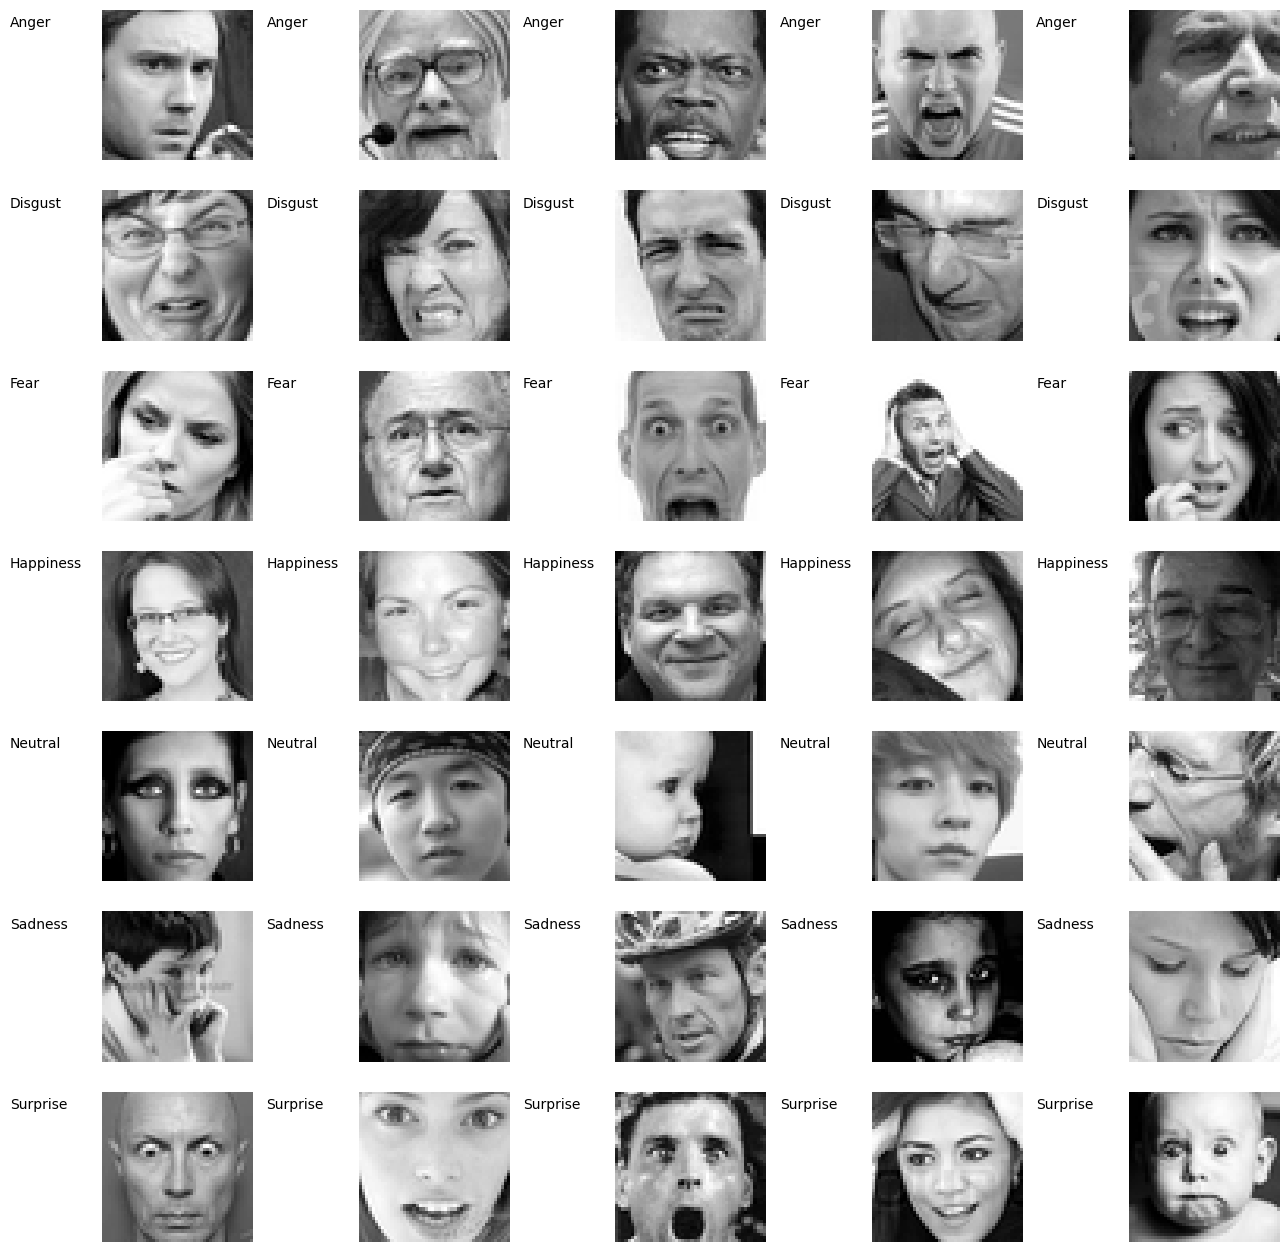

In [8]:
#Displaying 5 sample images from each emotion

plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(labels):

    all_emotion_images = train[train['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotion

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10)
        plt.axis('off')
    row += 5

plt.show()

### Image Augmentation

Image augmentation is a technique for artificially creating data from a previously existing data set. The data is typically generated by flipping, rotating, shifting, zooming, and blurring. The newly created images are combined with the original training set in the hopes of improving a deep learning model's robustness and performance.

We will be implementing 6 ways to build dataset for the model using image augmentation
#### Image Rotation

> A rotation augmentation randomly rotates the image clockwise by a given number of degrees from 0 to 360.

#### Image Width Shifting

> A shift to an image means moving all pixels of the image in one direction, such as horizontally, while keeping the image dimensions the same.

#### Image Height Shifting

> A shift to an image means moving all pixels of the image in one direction, such as vertically, while keeping the image dimensions the same.

#### Image Zooming

> A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.

#### Image Flipping

> An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

#### Image Brightness

> The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.
The intent is to allow a model to generalize across images trained on different lighting levels.

In [9]:
# Generating an images

train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    fill_mode = 'nearest'
)

# Using only one image for an example

im_aug_example = train_datagen.flow(train['pixels'][0], batch_size=1)

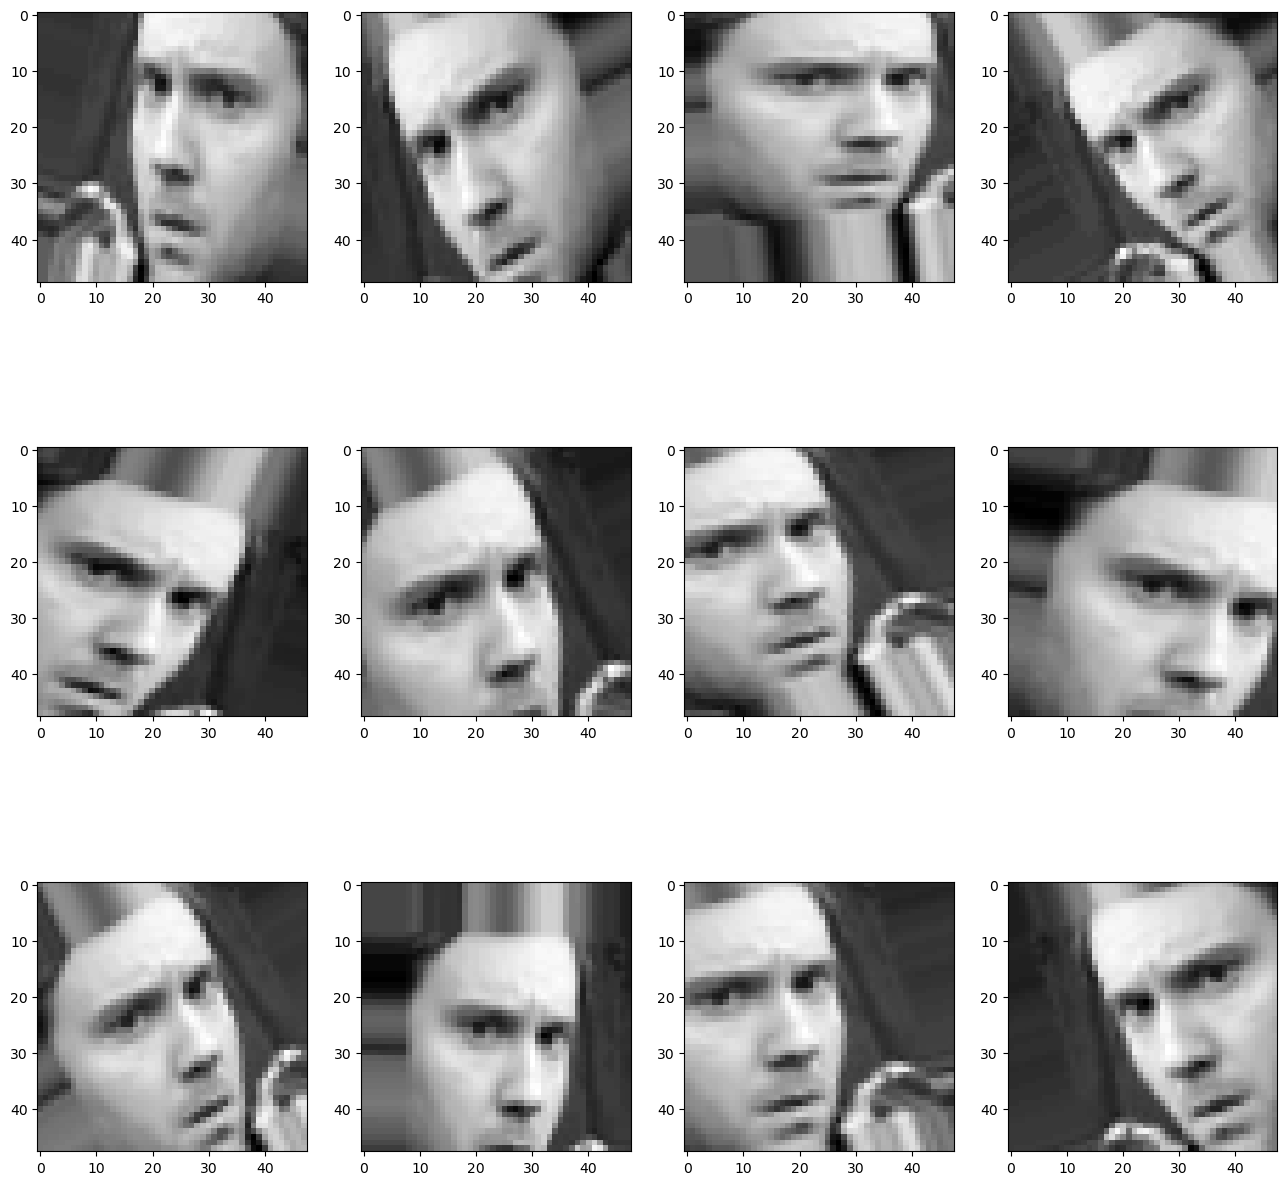

In [10]:
# Create plot for image augmentation

plt.close()
plt.rcParams["figure.figsize"] = [16,16]

for i in range(12):
    # preparing the subplot
    plt.subplot(3,4,i+1)
    
    # generating images in batches
    batch = im_aug_example.next()
    
    # Remember to convert these images to unsigned integers for viewing 
    image = batch[0].astype('uint8')
    
    # Plotting the data
    plt.imshow(image,cmap='binary_r')
    
# Displaying the figure
plt.show()

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
The plot above shows that all twelve images have the same face and thus the same emotion. However, due to the augmentation, each image is slightly different. This reduces our model's ability to remember training instances. It also expands our training set, which is useful for smaller data sets.
    
</div>

## Model Implementation

![CNN](https://editor.analyticsvidhya.com/uploads/999181_BIpRgx5FsEMhr1k2EqBKFg.gif "CNN")

### Convolutional Neural Network

> We use these sample images to get a sense of the distinguishing characteristics of each emotion. Our CNN model's goal is to identify these features through training and use them to correctly predict the emotion of images that the model has not seen.

In [11]:
# Since my labels are strings, converting it to float

label_encoder = LabelEncoder()
labels = np.array(label_encoder.fit_transform(labels))

### Split, Reshape, and Scale Datasets

> We split the data into training and validation sets using a stratified fashion, and scale the pixels values between 0 and 1.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48, 1)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48, 1)
y_valid Shape: (5742,)


In [13]:
Xs_train = X_train / 255
Xs_valid = X_valid / 255

### Build CNN Network

> We set the seed so that each training run produces the same results. We construct the convolutional neural network by alternating between 2D convolution layers and densely connected layers. We also include max pooling, dropout, and batch normalization.

In [14]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    Conv2D(64, (3,3), activation = 'relu', padding = 'same', input_shape=(48,48,1)),
    Conv2D(64, (5,5), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

### Train CNN Network

> We train the model using the Adam optimizer, a learning rate of 0.001, and sparse categorical crossentropy loss.

In [15]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
# For capturing the execution time
# %%time 

# h1 = cnn.fit(
#     Xs_train, y_train, 
#     batch_size=256,
#     epochs = 20,
#     verbose = 1,
#     validation_data = (Xs_valid, y_valid)
# )

<div class="alert alert-block alert-info">
<b>Observation:</b>

We use image augmentation to explore the dataset during project. We implemented a convolutional neural network to see how well it worked on the set. The CNN can be seen below. Our accuracy score was ~60%.
    
</div>

In [17]:
# history = h1.history
# print(history.keys())

In [18]:
# Loading the saved model
history = load(open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_cnn.pkl', 'rb'))
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
#Get the best accuracy of the model

best_model_accuracy = history['accuracy'][np.argmin(history['loss'])]
print(best_model_accuracy)

0.629337728023529


<div class="alert alert-block alert-info">
<b>Observation:</b>
    
The model accuracy turned out to be 62.93%
    
</div>

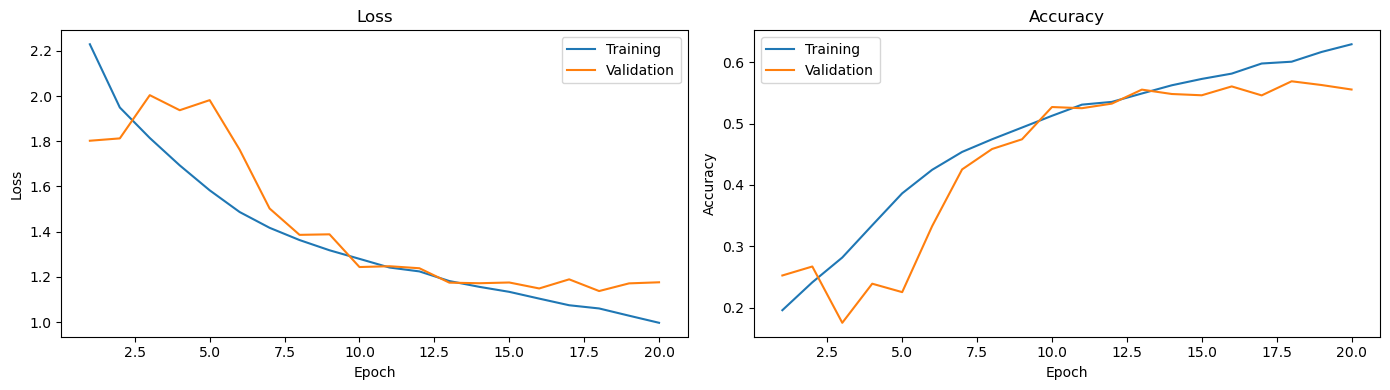

In [20]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
From the leaning curves we can conclude the model is training well, between 55-60%; however, there is room for improvement. There is slight overfitting, and the model could benefit from additional epochs.
    
</div>

### Save CNN Model and History

In [21]:
# cnn.save('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_model_cnn.h5')
# pickle.dump(history, open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_cnn.pkl', 'wb'))

## Transfer Learning Architecture
1) ResNet50 Architecture

2) Xception Architecture

### ResNet50 Architecture

> ResNet50 was trained on RGB images, whereas our data is grayscale. To use the ResNet50 model's pretrained weights, we must convert our images' single grayscale channel into three channels (RGB).

In [22]:
train = pd.read_csv('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/train.csv')

In [23]:
train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48) for x in train['pixels']]

In [24]:
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48)
(28709,)


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48)
y_valid Shape: (5742,)


In [26]:
rgb_X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
print(rgb_X_train.shape)

rgb_X_valid = np.repeat(X_valid[..., np.newaxis], 3, -1)
print(rgb_X_valid.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)


In [27]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    zoom_range = 0.3, 
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    fill_mode = 'reflect'
)

train_loader = train_datagen.flow(rgb_X_train, y_train, batch_size=64)

> Transfer Learning with ResNet50
We load the pretrained ResNet50 model and set trainable to false.

In [28]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(48,48,3))

resnet_model.trainable = False
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 12, 12, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 12, 12, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 12, 12, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 6, 6, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 6, 6, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 3, 3, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 3, 3, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 3, 3, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 3, 3, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 3, 3, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 3, 3, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 3, 3, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

> To the ResNet50 model we add densely-connected layers, incorporating dropout and batch normalization.

In [29]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    resnet_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 batch_normalization_3 (Batc  (None, 2, 2, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [30]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [31]:
# %%time 

# h1 = cnn.fit(
#     train_loader, 
#     batch_size=32,
#     epochs = 30,
#     verbose = 1,
#     validation_data = (rgb_X_valid, y_valid)
# )

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
The ResNet50 architecture didnot perform better than CNN; the overall performance was poor compared to our convolutional neural network. The highest accuracy we accomplished with this model was ~31%.
    
</div>

In [32]:
# history = h1.history
# print(history.keys())

In [33]:
# Loading the saved model
history = load(open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_resnet.pkl', 'rb'))
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [34]:
#Get the best accuracy of the model

best_model_accuracy = history['accuracy'][np.argmin(history['loss'])]
print(best_model_accuracy)

0.3185440003871918


<div class="alert alert-block alert-info">
<b>Observation:</b>
    
The model accuracy turned out to be 31.85%
    
</div>

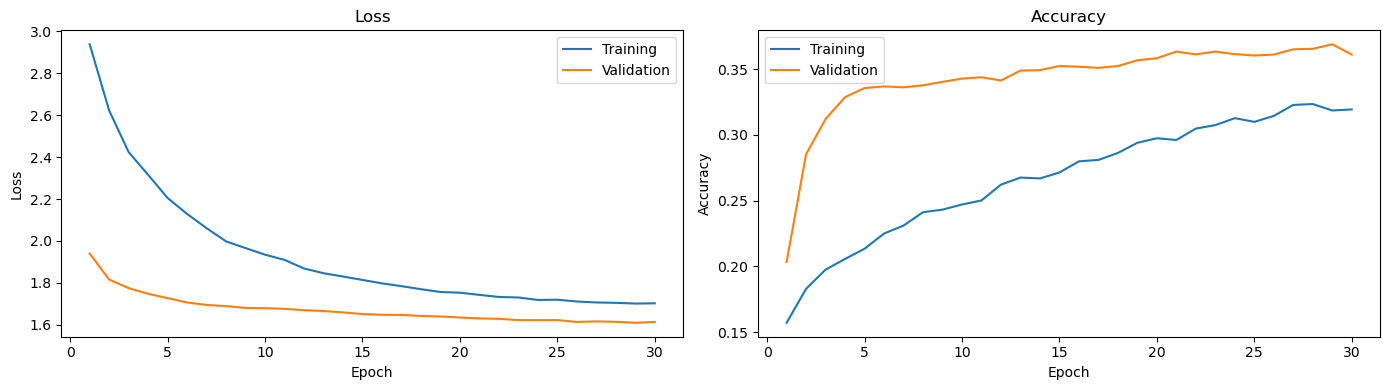

In [35]:
# View plots of loss and accuracy

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
From the learning curves we can see there is slight overfitting.
    
</div>

In [36]:
# cnn.save('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_model_resnet.h5')
# pickle.dump(history, open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_resnet.pkl', 'wb'))

### Xception Architecture

In [37]:
train = pd.read_csv('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [38]:
# Convert the string of pixels to an array
train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train['pixels']]

In [39]:
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48, 1)
(28709,)


In [40]:
# Since my labels are strings, converting it to float

label_encoder = LabelEncoder()
labels = np.array(label_encoder.fit_transform(labels))

In [41]:
# Split the data into a training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


# View the shapes of the data sets
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48, 1)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48, 1)
y_valid Shape: (5742,)


In [42]:
Xs_train = X_train / 255
Xs_valid = X_valid / 255

In [43]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_loader = train_datagen.flow(Xs_train, y_train, batch_size=64)

### Build Xception Model

> The code for the Xecption model is taken from [reference](https://colab.research.google.com/github/mavenzer/Autism-Detection-Using_YOLO/blob/master/Tutorial_implementing_Xception_in_TensorFlow_2_0_using_the_Functional_API.ipynb#scrollTo=uy3q-iLm3VV2 ) since the TensorFlow package requires an image size of at least 71x71.

In [44]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)           
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x


def middle_flow(x, num_blocks=8):
  
  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
  return x


def exit_flow(x, num_classes=7):
  
  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation)(x)

inputs = keras.Input(shape=(48, 48, 1))  # Variable-size image inputs.
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

In [45]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = xception
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 24, 24, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 24, 24, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 24, 24, 32)   0           ['batch_normalization_7[0][0]

 conv2d_8 (Conv2D)              (None, 3, 3, 728)    187096      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 3, 3, 728)    0           ['max_pooling2d_4[0][0]',        
                                                                  'conv2d_8[0][0]']               
                                                                                                  
 activation_8 (Activation)      (None, 3, 3, 728)    0           ['add_2[0][0]']                  
                                                                                                  
 separable_conv2d_6 (SeparableC  (None, 3, 3, 728)   537264      ['activation_8[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_nor

 add_5 (Add)                    (None, 3, 3, 728)    0           ['batch_normalization_23[0][0]', 
                                                                  'add_4[0][0]']                  
                                                                                                  
 activation_17 (Activation)     (None, 3, 3, 728)    0           ['add_5[0][0]']                  
                                                                                                  
 separable_conv2d_15 (Separable  (None, 3, 3, 728)   537264      ['activation_17[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_24 (BatchN  (None, 3, 3, 728)   2912        ['separable_conv2d_15[0][0]']    
 ormalization)                                                                                    
          

                                                                                                  
 activation_26 (Activation)     (None, 3, 3, 728)    0           ['add_8[0][0]']                  
                                                                                                  
 separable_conv2d_24 (Separable  (None, 3, 3, 728)   537264      ['activation_26[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_33 (BatchN  (None, 3, 3, 728)   2912        ['separable_conv2d_24[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 3, 3, 728)    0           ['batch_normalization_33[0][0]'] 
          

                                                                                                  
 activation_34 (Activation)     (None, 2, 2, 1536)   0           ['batch_normalization_41[0][0]'] 
                                                                                                  
 separable_conv2d_33 (Separable  (None, 2, 2, 2048)  3161600     ['activation_34[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 2, 2, 2048)  8192        ['separable_conv2d_33[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_35 (Activation)     (None, 2, 2, 2048)   0           ['batch_normalization_42[0][0]'] 
          

In [46]:
# Set up the optimizer
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [47]:
# %%time

# h1 = cnn.fit(train_loader, 
#              batch_size=256, 
#              epochs=30, 
#              validation_data=(Xs_valid, y_valid), verbose=1)

In [48]:
# # Save history and 
# history = h1.history

In [49]:
# Loading the saved model
history = load(open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_xception.pkl', 'rb'))
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [50]:
#Get the best accuracy of the model

best_model_accuracy = history['accuracy'][np.argmin(history['loss'])]
print(best_model_accuracy)

0.6144468188285828


<div class="alert alert-block alert-info">
<b>Observation:</b>
    
The model accuracy turned out to be 61.44%
    
</div>

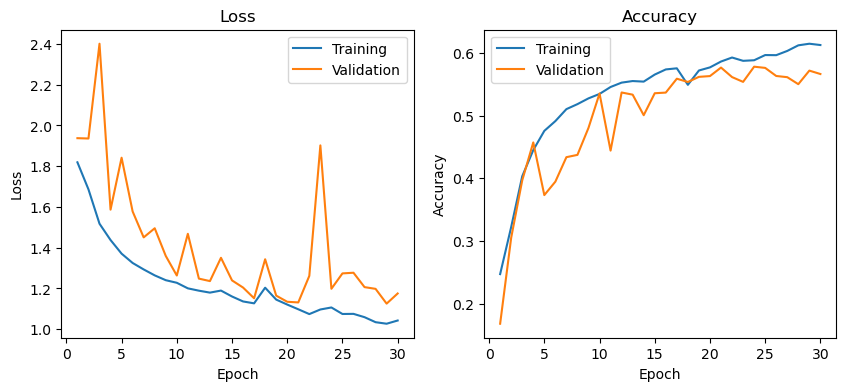

In [51]:
#View plots of loss and accuracy

n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')

plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<b>Observation:</b>
    
We notice that the graphs for the accuracy and loss are not very smooth. This indicates that we need to reduce the learning rate. The purpose of decreasing the learning rate is to allow our model to approach the optimal solution. When the learning rate is too large, the model tends to quickly converge on a suboptimal solution.
    
</div>

In [52]:
# cnn.save('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_model_xception.h5')
# pickle.dump(history, open(f'/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/Model/fer_xception.pkl', 'wb'))

## Summary

> In the end, we selected the CNN model. We achieved a 62% accuracy on the test set. Those results can be observed in the following classification reports:

In [53]:
# Read in full data set
data = pd.read_csv('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/Final_Project/icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']
print(data.shape)

(35887, 3)


In [54]:
# Select only rows that are in the public or private test set
test = data.loc[data["Usage"] != 'Training',['emotion','pixels']]

#test.drop(columns='Usage', inplace=True)
test.head()

,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [55]:
# Reshape the pixels

test['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in test['pixels']]

In [56]:
# Combine pixels into single array

pixels = np.concatenate(test['pixels'].values)

print(pixels.shape)

(7178, 48, 48, 1)


In [57]:
# Standardize the pixels values between 0 and 1

pixels = pixels / 255

In [58]:
model = load_model('/Users/pravin/Documents/Northeastern_MSIS/Fall_2022/fer_model_cnn.h5')
test_probs = model.predict(pixels)
test_pred = np.argmax(test_probs, axis=1)

2022-12-08 17:25:22.454337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


225/225 [==============================] - 19s 82ms/step


In [59]:
test['predictions'] = test_pred
test.head()

,emotion,pixels,predictions
28709,0,"[[[[254], [254], [254], [254], [254], [249], [...",0
28710,1,"[[[[156], [184], [198], [202], [204], [207], [...",4
28711,4,"[[[[69], [118], [61], [60], [96], [121], [103]...",0
28712,6,"[[[[205], [203], [236], [157], [83], [158], [1...",5
28713,3,"[[[[87], [79], [74], [66], [74], [96], [77], [...",3


In [60]:
# Assign labels to each value

emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}
test['emotion'] = test['emotion'].apply(lambda x: emotion_cat[x])
test['predictions'] = test['predictions'].apply(lambda x: emotion_cat[x])

In [61]:
# Generate the classification report

my_classification_report = classification_report(test['emotion'], test['predictions'])
print(my_classification_report)

              precision    recall  f1-score   support

       Anger       0.47      0.48      0.48       958
     Disgust       0.82      0.32      0.46       111
        Fear       0.45      0.28      0.34      1024
   Happiness       0.82      0.78      0.80      1774
     Neutral       0.01      0.01      0.01      1233
     Sadness       0.16      0.17      0.17      1247
    Surprise       0.02      0.05      0.03       831

    accuracy                           0.34      7178
   macro avg       0.39      0.30      0.33      7178
weighted avg       0.38      0.34      0.35      7178



In [62]:
# Total number of incorrect predictions

print('Total Wrong Predictions:', np.sum(test['emotion'] != test['predictions']))

Total Wrong Predictions: 4749


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

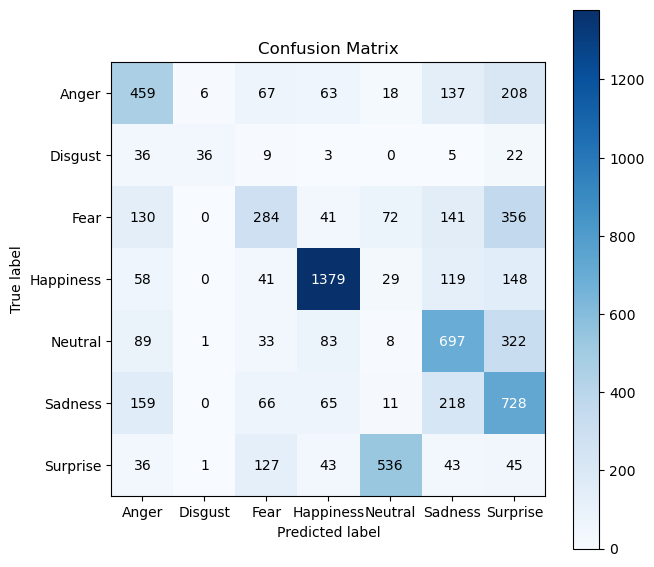

In [63]:
# Confusion Matrix

scikitplot.metrics.plot_confusion_matrix(test['emotion'], test['predictions'], figsize=(7,7))    

In [64]:
# View shape of probabilites

test_probs.shape

(7178, 7)

In [65]:
# Compute Top-N accuracy for each class

for k in range(0, 7):
    print(f"{emotion_cat[k]} top accuracy: {round(top_k_accuracy_score(test['emotion'], test_probs, k=k), 2)}")

Anger top accuracy: 0.0
Disgust top accuracy: 0.57
Fear top accuracy: 0.77
Happiness top accuracy: 0.87
Sadness top accuracy: 0.94
Surprise top accuracy: 0.98
Neutral top accuracy: 0.99


## Challenges
- We didn't have any images with which we can train our model. Instead, we have the pixels from each image.
- The lack of labeled data for one class (i.e disgust)
- Recognizing incomplete emotions (e.g. Anger and Disgust seems to be having similar feature due to which we achieved low accuracy)

## References

* https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6514576/
* https://colab.research.google.com/github/mavenzer/Autism-Detection-Using_YOLO/blob/master/Tutorial_implementing_Xception_in_TensorFlow_2_0_using_the_Functional_API.ipynb#scrollTo=_cwgleGGqE9T
* https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/
* https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
* https://www.kaggle.com/code/drbeane/transfer-learning-tutorial-cifar-10/notebook
* https://keras.io/guides/transfer_learning/#do-a-round-of-finetuning-of-the-entire-model

***